In [200]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint

In [201]:
# Parameters 
L = 40 # length of domain 
dx = 0.2 # mesh steps 
nx = int(L / dx) # mesh points
k0s = np.linspace(0.1, 4, nx) # momentum of wave pakcket [au] (0.01 to 5) with nx points
# T = L / (2 * k0s) # total time 
dt = 2 * dx**2 # time step 
# nt = (T / dt) # time points 

x = np.linspace(0, L, nx)
# print((k0s))


In [202]:
# Gaussian wave packet
def get_psi0(k0): 
    x0 = L / 4  # center of the wave packet
    sigma = L / 20  # width of the wave packet
    N = (np.pi * sigma ** 2)**(-1/4) # Normalization 
    gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
    phase = np.exp(1j * k0 * x) 
    psi0 = (gaussian * phase) * N # initial wave function
    # norm = np.sum(psi0 * np.conj(psi0)) * dx # check in psi0 is normalized
    # print(norm)
    return psi0 

In [203]:
# Potential initial conditions 
def get_pot(V0, a): 
    # V0 = 1 # potential strength
    # a = 0.05 # potential width percentage 
    V = np.zeros(nx)
    V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 
    return V


In [204]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator must be less than one to be stable

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu 

aplus_inv = np.linalg.inv(aplus)


In [205]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu  

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu 

In [206]:
# Crank-Nicholson
def get_psi(V, V0):

    for k0 in k0s:
        if k0**2 < V0:
            current_T = L / (k0) * 0.3
        else: 
            current_T = L / k0 * 0.75

        current_nt = int(current_T / dt) 
        psi0 = get_psi0(k0)

        for t in range(current_nt): 
            f = np.exp(-1j * dt * V) * psi0
            psi = np.dot(aplus_inv, np.dot(aminus, f))
            psi0 = psi

        # second_derivative = np.gradient(np.gradient(psi0, dx), dx)
        # print(k0, second_derivative)

            
        # print(k0 * dt / dx)

 # # plotting 
        #     if 1.01 > k0 > 1.0 and t % 50 == 0:
        #         plt.figure(figsize=(10, 300))
        #         num_cols = 2  # Number of columns for subplots
        #         num_rows = (current_nt + num_cols - 1) // num_cols

        #         plt.subplot(num_rows, num_cols, t + 1)
        #         plt.plot(x, np.abs(psi)**2)
        #         plt.plot(x, V)
        #         plt.title(f'Time step: {t}, velocity: {k0}')
        #         plt.xlabel('Position')
        #         plt.ylabel('Wave function')
        #         plt.tight_layout()
        # plt.show()

        yield psi # will yield the final psi at each k0 each time the loop has completed 
        
# V0 = 1 # potential strength
# a = 0.05 # potential width percentage   
# V = get_pot(V0, a)
# get_psi(V)

# for psi_k0 in get_psi(V):
#     pass


In [207]:
def analytical(V0, a):
    E = np.array(k0s)**2 
    # V0_2 = np.array(V0_vals)**2

    # V0 = 1
    # # R0 = 0.05 * L
    R0 = a * L / 2


    # first_term = V0**2 / (4 * E * (E + V0))
    # second_term = second_term = np.sin(2 * R0 * np.sqrt(2 * (E + V0)))**2

    first_term = V0**2 * np.sin(2 * R0 * np.sqrt(2 * (E + V0)))**2
    second_term = (4 * E * (E + V0)) + first_term

    analytical_refl = first_term / second_term
    analytical_trans = 1 - analytical_refl
    # print(analytical_refl + analytical_trans)

    # plt.plot(E/V0, analytical_refl)
    # # plt.yscale('log')
    # plt.xlabel('E/V0')
    # plt.ylabel('R')
    # plt.show()

    # plt.plot(E, analytical_trans)
    # # plt.yscale('log')
    # plt.xlabel('E/V0')
    # plt.ylabel('T')
    # plt.show()

    return(analytical_refl, analytical_trans)



In [208]:
def getRandT(final_psis, V0, a):
    center = int(nx/2) # center of well
    rcoefs = []
    tcoefs = []

    for psi in final_psis: 
        reflected_wavefunction = psi[0: center]
        transmitted_wavefunction = psi[center: nx] 
        refl = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx
        trans = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx
        rcoefs.append(np.real(refl))
        tcoefs.append(np.real(trans))
        # print(np.sum(psi * np.conj(psi)) * dx )# check in psi0 is normalized


    # print(f"Reflection coefficient (R): {rcoefs}")
    # print(f"Transmission coefficient (T): {tcoefs}")
    
    analytical_refl, analytical_trans = analytical(V0, a)
    # %matplotlib inline
    es = k0s**2 / np.array(V0) # unitless energy

    plt.plot(es, rcoefs, label = 'R')
    plt.plot(es, analytical_refl, label = 'R analytical')
    plt.plot(es, tcoefs, label = 'T')
    plt.plot(es, analytical_trans, label = 'T analytical')
    plt.xlabel("energy (k0^2 / V0)")
    plt.ylabel('Refl & trans coefs')
    plt.title(f'V0 = {V0}, a = {a}')
    # plt.yscale('log')
    plt.legend()
    plt.show()

    return rcoefs, tcoefs

# V0 = 1 # potential strength
# a = 0.05 # potential width percentage 
# V = get_pot(V0, a)
# final_psis = get_psi(V, V0)
# rcoefs, tcoefs = getRandT(final_psis, V0, a)



In [209]:
def gen_varyingpot():
    V0 = 1 # potential strength
    a = 0.05 # potential width percentage 
    
    while V0 <= 3:
        while a <= 0.2:
            V = get_pot(V0, a)
            final_psis = get_psi(V, V0)
            rcoefs, tcoefs = getRandT(final_psis, V0, a)
            for (k0, rcoef, tcoef) in zip(k0s, rcoefs, tcoefs):
                yield(k0, V0, a, rcoef, tcoef)
            # plot_results(V0, a, rcoefs, tcoefs)
            a += 0.05
            a = round(a, 2)
        a = 0.05 # reset a for next V0
        V0 += 1

# gen_varyingpot()

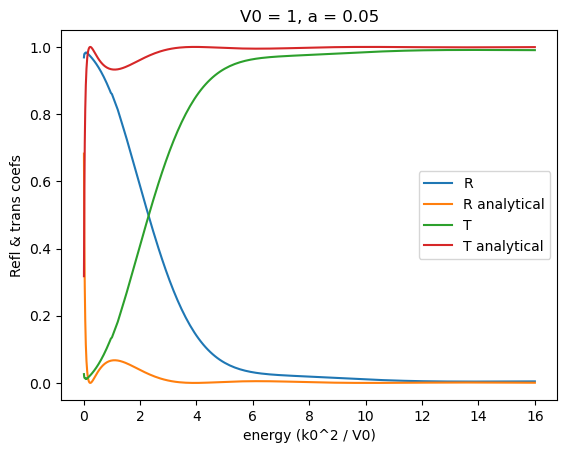

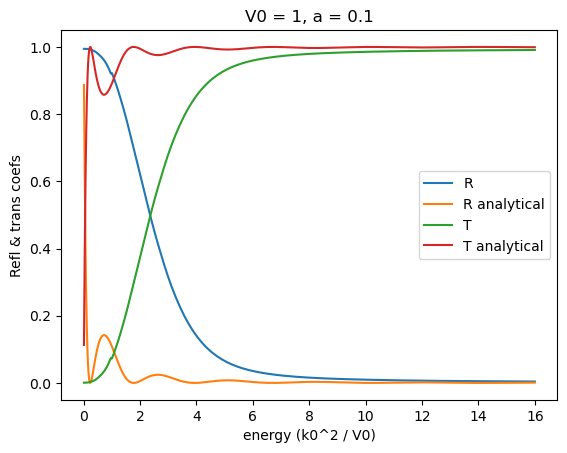

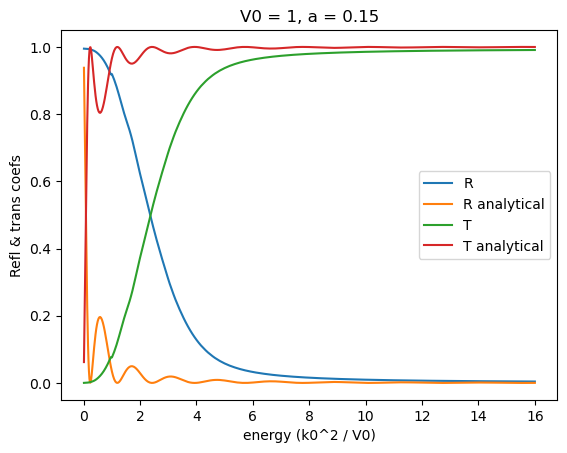

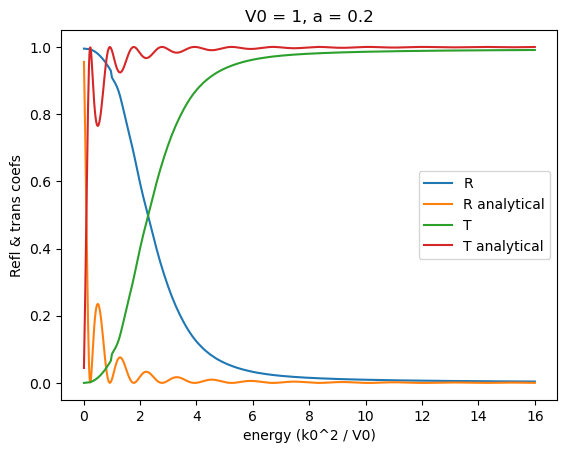

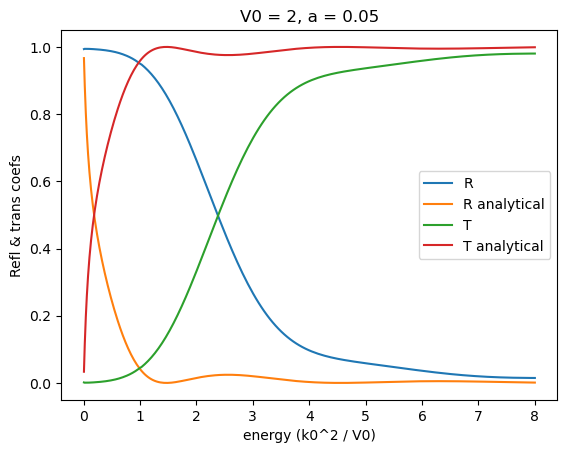

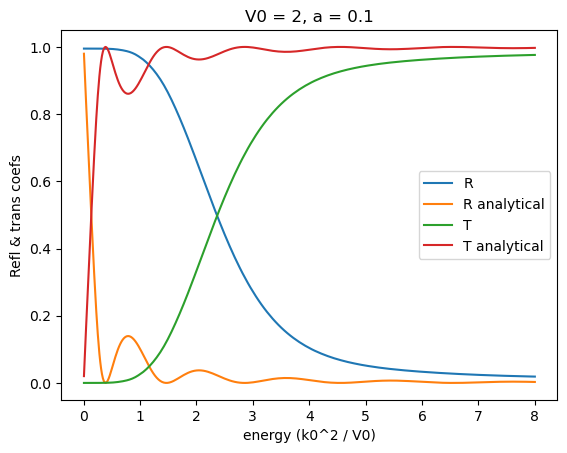

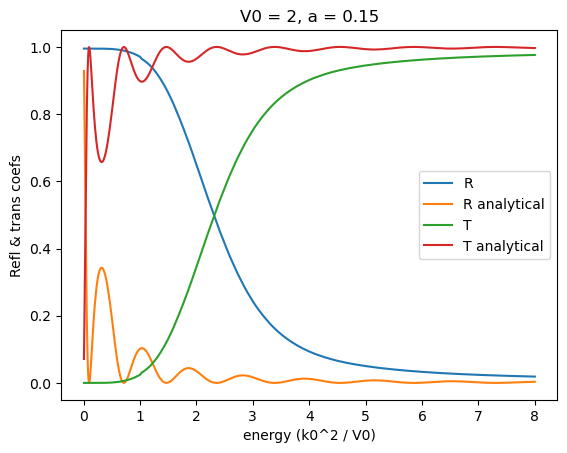

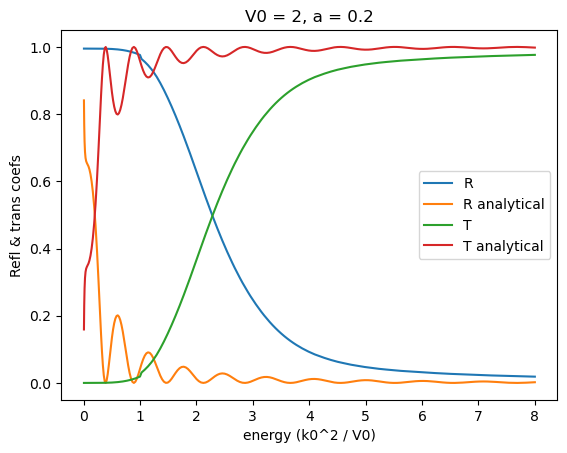

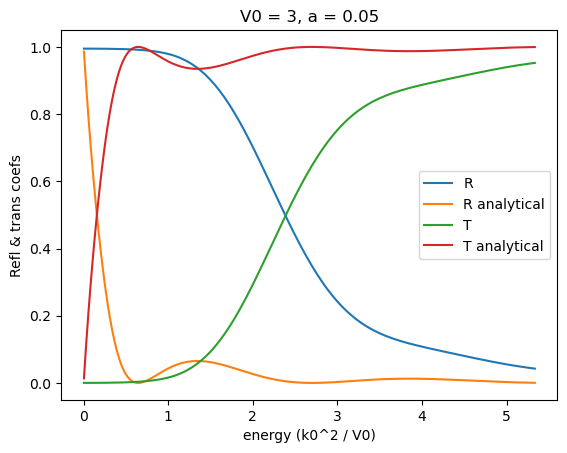

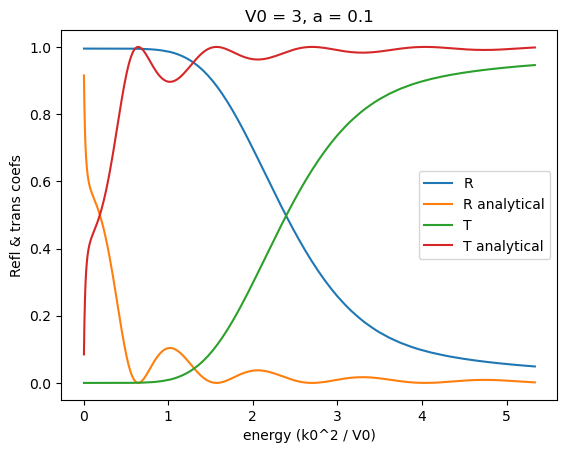

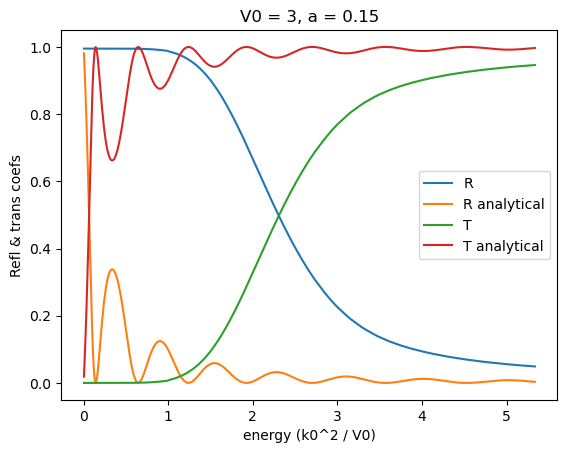

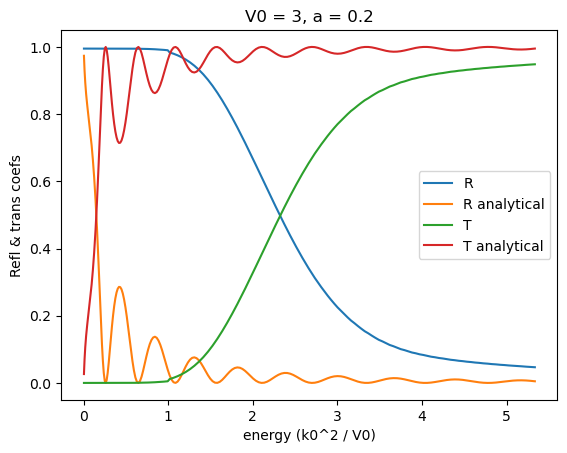

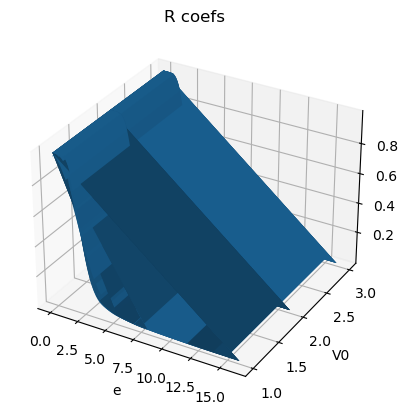

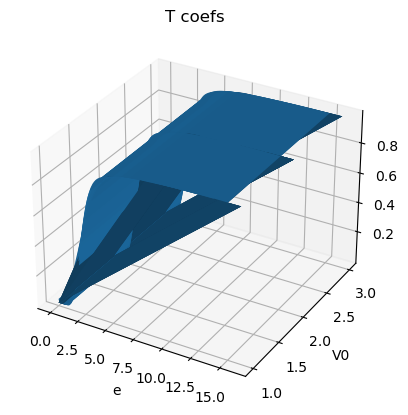

In [210]:
def get_plots():
    k0_vals = []
    V0_vals = []
    a_vals = []
    refl_coefs = []
    trans_coefs = []

    for varypoint in gen_varyingpot():
        k0_val, V0_val, a_val, refl_coef, trans_coef = varypoint
        k0_vals.append(k0_val)
        V0_vals.append(V0_val)
        a_vals.append(a_val)
        refl_coefs.append(refl_coef)
        trans_coefs.append(trans_coef)

    k0_vals = np.array(k0_vals)
    V0_vals = np.array(V0_vals)
    a_vals = np.array(a_vals)
    refl_coefs = np.array(refl_coefs)
    trans_coefs = np.array(trans_coefs)

    
    ## 3D plots 
    unitless_energy = k0_vals**2 / V0_vals

    unitless_e_2d, V0_2d = np.meshgrid(unitless_energy, V0_vals)

    refl_coefs_reshaped = refl_coefs.reshape(1,len(refl_coefs))

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')

    ax1.plot_surface(unitless_e_2d, V0_2d, refl_coefs_reshaped)
    ax1.set_xlabel('e')
    ax1.set_ylabel('V0')
    ax1.set_zlabel('R')
    ax1.set_title('R coefs')
    plt.show(fig1)

    # cbar_c1 = fig.colorbar(scatter_c1, label='R')
    # cbar_c2 = fig.colorbar(scatter_c2, label='T')
    # ax.legend()

    # %matplotlib widget
    # ax.view_init(elev=20, azim=30)
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')

    trans_coefs_reshaped = trans_coefs.reshape(1,len(refl_coefs))

    ax2.plot_surface(unitless_e_2d, V0_2d, trans_coefs_reshaped)
    ax2.set_xlabel('e')
    ax2.set_ylabel('V0')
    ax2.set_zlabel('T')
    ax2.set_title('T coefs')

    plt.show(fig2)
    return

get_plots()
    

